
#### _ML продвинутые методы / ДЗ №3 / Stacking & blending_

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## 1. _Подготовка данных_

In [3]:
X = pd.read_csv('../../03-boosting/train_medium.csv')
y = X['Disbursed']

X_test = pd.read_csv('../../03-boosting/test_medium.csv')
y_test = X_test['Disbursed']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

X, X_train, X_test, X_val = [ x.drop('Disbursed', 1) for x in [X, X_train, X_test, X_val] ]

[ a.shape for a in [X, y, X_train, y_train, X_val, y_val, X_test, y_test] ]

[(65265, 50),
 (65265,),
 (48948, 50),
 (48948,),
 (16317, 50),
 (16317,),
 (21755, 50),
 (21755,)]

### 1.1 _PCA_

In [4]:
def plot_pca(X, y):
    plt.figure(figsize=(17,10))

    for u in sorted(y.unique()):
        ix = np.argwhere(y == u).squeeze()
        plt.plot(X[ix, 0], X[ix, 1], 'o', label='class {}'.format(u))

    plt.legend();

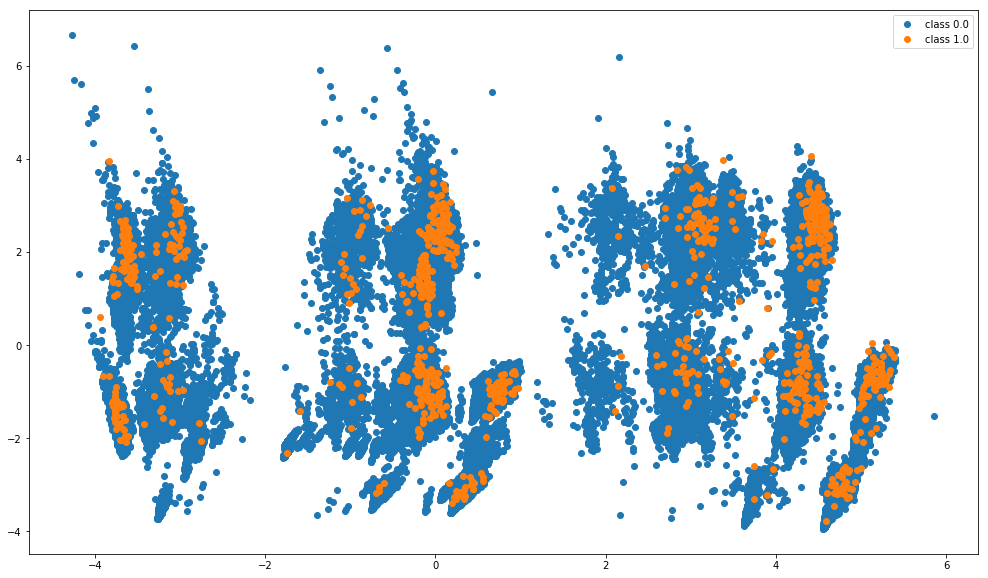

In [5]:
pca = Pipeline([
            ('scaler', StandardScaler()), 
            ('pca', PCA(n_components=2))
        ])

X_pca = pca.fit_transform(X.astype('float64'))

plot_pca(X_pca, y)

In [6]:
for i, component in enumerate(pca.named_steps['pca'].components_):
    print("Component #{}: {:.2f}% of initial variance".format(i + 1, 100 * pca.named_steps['pca'].explained_variance_ratio_[i], 2))

Component #1: 19.15% of initial variance
Component #2: 8.19% of initial variance


По двум компонентам классы плохо разделимы.

## 2. _Базовые алгоритмы_

In [7]:
def print_scores(dataset_name, y_true, y_pred, y_proba):
    print("[{}]".format(dataset_name))
    print("Accuracy : {:.3f}".format(metrics.accuracy_score(y_true, y_pred)))
    print("AUC Score [class {:.0f}]: {:.3f}".format(y_proba.shape[1]-1, metrics.roc_auc_score(y_true, y_proba[:,y_proba.shape[1]-1])))
    print(metrics.classification_report(y_true, y_pred, digits=3))
    print(60 * "*")

### 2.1 _Random Forest_

In [8]:
%%time

rf = RandomForestClassifier(n_estimators=100)

print(cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc').mean())

0.7604227578524767
Wall time: 16.8 s


### 2.1 _RandomForest_

In [9]:
rf.fit(X_train, y_train)

rf_test_proba = rf.predict_proba(X_test)

print_scores('RandomForestClassifier; test', y_test, rf.predict(X_test), rf_test_proba)

[RandomForestClassifier; test]
Accuracy : 0.985
AUC Score [class 1]: 0.762
              precision    recall  f1-score   support

         0.0      0.985     1.000     0.992     21431
         1.0      0.250     0.003     0.006       324

   micro avg      0.985     0.985     0.985     21755
   macro avg      0.618     0.501     0.499     21755
weighted avg      0.974     0.985     0.978     21755

************************************************************


### 2.2 _Logistic Regression_

In [10]:
%%time

lr = LogisticRegression(solver='lbfgs')

# UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
# 
# -> поэтому используем roc_auc
print(cross_val_score(lr, X_train, y_train, cv=5, scoring='roc_auc').mean())

0.43145942818658545
Wall time: 3.31 s


In [11]:
lr.fit(X_train, y_train)

lr_test_proba = lr.predict_proba(X_test)

print_scores('LogisticRegression; test', y_test, lr.predict(X_test), lr_test_proba)

[LogisticRegression; test]
Accuracy : 0.985
AUC Score [class 1]: 0.435
              precision    recall  f1-score   support

         0.0      0.985     1.000     0.992     21431
         1.0      0.000     0.000     0.000       324

   micro avg      0.985     0.985     0.985     21755
   macro avg      0.493     0.500     0.496     21755
weighted avg      0.970     0.985     0.978     21755

************************************************************


C:\Users\roma\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 2.3 _Ada Boost_

In [12]:
%%time

ada = AdaBoostClassifier(learning_rate=0.1)

print(cross_val_score(ada, X_train, y_train, cv=5, scoring='roc_auc').mean())

0.8177599330137827
Wall time: 9.44 s


In [13]:
ada.fit(X_train, y_train)

ada_test_proba = ada.predict_proba(X_test)

print_scores('AdaBoostClassifier; test', y_test, ada.predict(X_test), ada_test_proba)

[AdaBoostClassifier; test]
Accuracy : 0.985
AUC Score [class 1]: 0.826
              precision    recall  f1-score   support

         0.0      0.985     1.000     0.992     21431
         1.0      0.000     0.000     0.000       324

   micro avg      0.985     0.985     0.985     21755
   macro avg      0.493     0.500     0.496     21755
weighted avg      0.970     0.985     0.978     21755

************************************************************


C:\Users\roma\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 3. _Blending_

In [14]:
mix_pred = (1/3)*rf_test_proba + (1/4)*lr_test_proba + (5/12)*ada_test_proba

y_blend_pred = [np.argmax(x) for x in mix_pred]

print_scores('Blending', y_test, y_blend_pred, mix_pred)

[Blending]
Accuracy : 0.985
AUC Score [class 1]: 0.824
              precision    recall  f1-score   support

         0.0      0.985     1.000     0.992     21431
         1.0      0.000     0.000     0.000       324

   micro avg      0.985     0.985     0.985     21755
   macro avg      0.493     0.500     0.496     21755
weighted avg      0.970     0.985     0.978     21755

************************************************************


C:\Users\roma\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 4. _Stacking_

_Здесь я не совсем понял, вероятности для какого класса лучше использовать в качестве метапризнаков_.

In [15]:
S_train = pd.DataFrame(
    list(zip(rf.predict_proba(X_val)[:,0], 
             lr.predict_proba(X_val)[:,0], 
             ada.predict_proba(X_val)[:,0])), 
    columns=['RF', 'LR', 'ADA'])

S_train.head()

,RF,LR,ADA
0,1.0,0.994904,0.943472
1,0.9,0.969677,0.650978
2,1.0,0.995266,0.721532
3,1.0,0.992553,0.709824
4,1.0,0.950296,0.754405


In [16]:
meta = LogisticRegression(solver='lbfgs')

meta.fit(S_train, y_val)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [17]:
S_test = pd.DataFrame(
    list(zip(rf_test_proba[:,0], 
             lr_test_proba[:,0], 
             ada_test_proba[:,0])), 
    columns=['RF', 'LR', 'ADA'])

S_test.head()

,RF,LR,ADA
0,1.00,0.976889,0.719095
1,1.00,0.993266,0.751365
2,1.00,0.969849,0.956584
3,0.99,0.995439,0.651949
4,1.00,0.965834,0.715648


In [18]:
stack_proba = meta.predict_proba(S_test)

y_stack_pred = [np.argmax(x) for x in stack_proba]

print(cross_val_score(meta, X_test, y_test, cv=5, scoring='roc_auc').mean())

0.4549453248613581


In [19]:
np.unique(y_stack_pred, return_counts=True)

(array([0], dtype=int64), array([21755], dtype=int64))

In [20]:
print_scores('Stacking', y_test, y_stack_pred, stack_proba)

[Stacking]
Accuracy : 0.985
AUC Score [class 1]: 0.827
              precision    recall  f1-score   support

         0.0      0.985     1.000     0.992     21431
         1.0      0.000     0.000     0.000       324

   micro avg      0.985     0.985     0.985     21755
   macro avg      0.493     0.500     0.496     21755
weighted avg      0.970     0.985     0.978     21755

************************************************************


C:\Users\roma\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 4.1 Stacking *ROC_AUC*, *PR_AUC*

In [21]:
def plot_curve_xy(x, y, class_label):    
    plt.plot(x, y, lw=3, label='Class {}'.format(class_label))

def plot_curve(nrc, curve, y_test, y_probs, title, xlabel, ylabel):
    plt.subplot(nrc)
    for class_label in range(y_probs.shape[1]):
        curve(y_test, y_probs, class_label)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    
def plot_roc_curve(y_test, y_probs, class_label):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs[:,class_label], pos_label=class_label)
    plot_curve_xy(fpr, tpr, class_label)

def plot_pr_curve(y_test, y_probs, class_label):
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_probs[:,class_label], pos_label=class_label)
    plot_curve_xy(recall, precision, class_label)

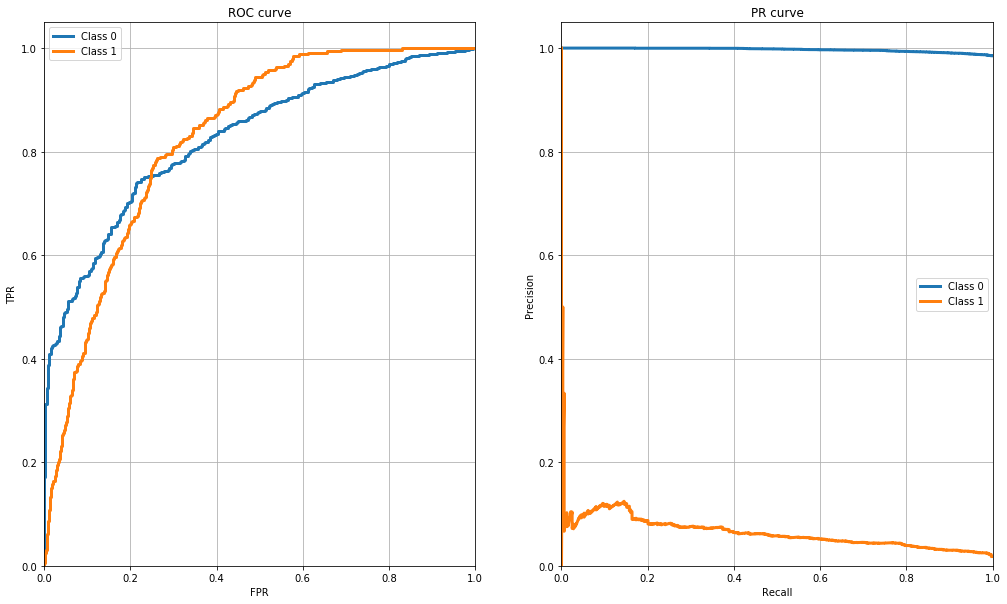

In [22]:
plt.figure(figsize=(17, 10))

plot_curve(121, plot_roc_curve, y_test, stack_proba, 'ROC curve', 'FPR', 'TPR')
plot_curve(122, plot_pr_curve, y_test, stack_proba, 'PR curve', 'Recall', 'Precision')

plt.show();

## 5. _vestack_

In [23]:
import vecstack

models = [RandomForestClassifier(n_estimators=100), 
          LogisticRegression(solver='lbfgs'),
          AdaBoostClassifier(learning_rate=0.05)]

S_train, S_test = vecstack.stacking(models, X, y, X_test, regression=False)

S_train.shape, S_test.shape

((65265, 3), (21755, 3))

In [24]:
%%time

meta = RandomForestClassifier(n_estimators=50)

meta.fit(S_train, y)

Wall time: 644 ms


In [25]:
vecstack_proba = meta.predict_proba(S_test)

y_vecstack_pred = meta.predict(S_test)

print(cross_val_score(meta, X_test, y_test, cv=5, scoring='roc_auc').mean())

0.7254878217782945


In [26]:
np.unique(y_vecstack_pred, return_counts=True)

(array([0.]), array([21755], dtype=int64))

In [27]:
np.unique(vecstack_proba, return_counts=True)

(array([0.01442256, 0.23537007, 0.76462993, 0.98557744]),
 array([21750,     5,     5, 21750], dtype=int64))

_Здесь он тоже не предсказал ни одного объекта класса <b>1</b> да ещё и почти всем объектам назначил одинаковые вероятности, что можно увидеть ниже по AUC_.

In [28]:
print_scores('vecstack', y_test, y_vecstack_pred, vecstack_proba)

[vecstack]
Accuracy : 0.985
AUC Score [class 1]: 0.500
              precision    recall  f1-score   support

         0.0      0.985     1.000     0.992     21431
         1.0      0.000     0.000     0.000       324

   micro avg      0.985     0.985     0.985     21755
   macro avg      0.493     0.500     0.496     21755
weighted avg      0.970     0.985     0.978     21755

************************************************************


C:\Users\roma\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 6. _Выводы_

1. `AUC Score` на тестовой выборке численно сопоставим с результатами `CatBoost` (кроме `vecstack`).
2. В то же время, оба метода не справляются с предсказанием класса <b>1</b>. Видимо, тут надо либо более тонко настраивать какие-то гиперпараметры алгоритмов, либо использовать алгоритмы [поиска аномалий](https://github.com/rklepov/hse-cs-ml-2018-2019/blob/homework/03-ML-basics/HW/hw4/hw4_anomalies.ipynb). 